In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse

# Load the data
train_data = pd.read_parquet("data/train_data.parquet")
# test_data = pd.read_parquet("data/test_data.parquet")
test_data = pd.read_csv("tmp/test_matched_full.csv")
# Convert expiry to datetime if it's not already
if train_data["expiry"].dtype != "datetime64[ns]":
    train_data["expiry"] = pd.to_datetime(train_data["expiry"])

# Get the target expiry date
target_date = pd.Timestamp("2025-05-08").date()


In [40]:
data_path = "data"
output_path = "output/"
temp_path = "tmp/"

sample_submission = pd.read_csv(f"{data_path}/sample_submission.csv")
submission_cols = sample_submission.columns.tolist()

In [41]:
# Filter rows with the specified expiry date
expiry_filter = train_data['expiry'].dt.date == target_date
target_rows = train_data[expiry_filter]

# Get indices of rows to be used for validation (50% of the rows with target expiry)
validation_indices = target_rows.sample(frac=0.5, random_state=43).index

# Create validation set
val_data = train_data.loc[validation_indices].copy()

# Remove validation data from training set
train_data = train_data.drop(validation_indices)

# Print shapes to confirm
print(f"Original training data shape: {len(train_data) + len(val_data)}")
print(f"New training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Original training data shape: 178340
New training data shape: (138752, 97)
Validation data shape: (39588, 97)
Test data shape: (12065, 96)


In [42]:
test_data.columns

Index(['timestamp', 'underlying', 'call_iv_24000', 'call_iv_24100',
       'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24500',
       'call_iv_24600', 'call_iv_24700', 'call_iv_24800', 'call_iv_24900',
       'call_iv_25000', 'call_iv_25100', 'call_iv_25200', 'call_iv_25300',
       'call_iv_25400', 'call_iv_25500', 'call_iv_25600', 'call_iv_25700',
       'call_iv_25800', 'call_iv_25900', 'call_iv_26000', 'call_iv_26100',
       'call_iv_26200', 'call_iv_26300', 'call_iv_26400', 'call_iv_26500',
       'put_iv_23000', 'put_iv_23100', 'put_iv_23200', 'put_iv_23300',
       'put_iv_23400', 'put_iv_23500', 'put_iv_23600', 'put_iv_23700',
       'put_iv_23800', 'put_iv_23900', 'put_iv_24000', 'put_iv_24100',
       'put_iv_24200', 'put_iv_24300', 'put_iv_24400', 'put_iv_24500',
       'put_iv_24600', 'put_iv_24700', 'put_iv_24800', 'put_iv_24900',
       'put_iv_25000', 'put_iv_25100', 'put_iv_25200', 'put_iv_25300',
       'put_iv_25400', 'put_iv_25500', 'X0', 'X1', 'X2',

In [43]:
train_data.columns

Index(['timestamp', 'underlying', 'expiry', 'call_iv_23500', 'call_iv_23600',
       'call_iv_23700', 'call_iv_23800', 'call_iv_23900', 'call_iv_24000',
       'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400',
       'call_iv_24500', 'call_iv_24600', 'call_iv_24700', 'call_iv_24800',
       'call_iv_24900', 'call_iv_25000', 'call_iv_25100', 'call_iv_25200',
       'call_iv_25300', 'call_iv_25400', 'call_iv_25500', 'call_iv_25600',
       'call_iv_25700', 'call_iv_25800', 'call_iv_25900', 'call_iv_26000',
       'put_iv_22500', 'put_iv_22600', 'put_iv_22700', 'put_iv_22800',
       'put_iv_22900', 'put_iv_23000', 'put_iv_23100', 'put_iv_23200',
       'put_iv_23300', 'put_iv_23400', 'put_iv_23500', 'put_iv_23600',
       'put_iv_23700', 'put_iv_23800', 'put_iv_23900', 'put_iv_24000',
       'put_iv_24100', 'put_iv_24200', 'put_iv_24300', 'put_iv_24400',
       'put_iv_24500', 'put_iv_24600', 'put_iv_24700', 'put_iv_24800',
       'put_iv_24900', 'put_iv_25000', 'X0', '

In [44]:
pred_cols = list(
    filter(
        lambda x: x.startswith("call") or x.startswith("put"), val_data.columns.tolist()
    )
)
len(pred_cols)

52

## Setting 32 columns to nan randomly in each row

In [45]:
import os
if os.path.exists(f"{temp_path}/sample_val.csv") and os.path.exists(
    f"{temp_path}/val_Y.csv"
):
    # If the sample files already exist, load them
    sample_val = pd.read_csv(f"{temp_path}/sample_val.csv")
    val_Y = pd.read_csv(f"{temp_path}/val_Y.csv")
    print("Loaded existing sample_val and val_Y.")
else:
    # Create a copy of val_data to avoid modifying the original
    sample_val = val_data.copy()

    # Get the call and put columns separately
    call_cols = [col for col in pred_cols if col.startswith("call")]
    put_cols = [col for col in pred_cols if col.startswith("put")]

    # For each row, randomly select 16 call columns and 16 put columns to set to NaN
    for idx in sample_val.index:
        # Randomly select 16 call columns for this row
        nan_call_cols = np.random.choice(call_cols, size=16, replace=False)

        # Randomly select 16 put columns for this row
        nan_put_cols = np.random.choice(put_cols, size=16, replace=False)

        # Set these columns to NaN for this row
        sample_val.loc[idx, nan_call_cols] = np.nan
        sample_val.loc[idx, nan_put_cols] = np.nan

    # Create val_Y from the original validation data, containing only the target columns
    val_Y = val_data[pred_cols]
    sample_val.to_csv(f"{temp_path}/sample_val.csv", index=False)
    val_Y.to_csv(f"{temp_path}/val_Y.csv", index=False)

Loaded existing sample_val and val_Y.


In [46]:
sample_val

,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,1746590742000000000,24433.0,2025-05-08,0.435793,NaN,NaN,0.35605,0.323607,NaN,NaN,...,-0.022656,0.006262,2.553592e+06,-0.001931,2.372125,0.068108,-1.522534e+06,-3.048516e+06,1.254699e+06,-0.000000e+00
1,1746176782000000000,24285.5,2025-05-08,0.206319,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003836,-0.004734,6.693594e+05,0.010055,1.315715,0.030237,5.235704e+04,-8.124241e+06,1.313372e+06,-1.000000e-06
2,1746520665000000000,24387.5,2025-05-08,NaN,0.270770,NaN,NaN,0.199588,0.173109,NaN,...,0.001037,0.003309,2.847738e+06,0.008796,0.648142,0.041674,3.459928e+05,-2.764208e+07,2.203250e+06,0.000000e+00
3,1746591359000000000,24384.6,2025-05-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.035097,-0.030470,-3.629051e+06,0.146150,-8.941554,1.278703,6.211531e+06,7.623811e+06,-5.587995e+05,3.208558e+06
4,1746165957000000000,24329.3,2025-05-08,0.211074,NaN,0.196625,NaN,0.181550,NaN,NaN,...,0.001900,0.002318,-1.051215e+06,0.026776,0.242156,0.025405,2.716713e+06,-3.698245e+06,-0.000000e+00,-0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39583,1746515731000000000,24393.6,2025-05-08,NaN,0.266833,NaN,NaN,0.199508,NaN,NaN,...,-0.008578,-0.004349,7.608529e+05,0.022286,0.276633,-0.049681,-3.766206e+05,3.310812e+06,0.000000e+00,0.000000e+00
39584,1746609873000000000,24362.1,2025-05-08,0.424743,NaN,0.360815,NaN,NaN,NaN,0.216435,...,0.006081,-0.001241,-5.956005e+06,-0.053984,-2.637237,0.118681,-7.248843e+05,-4.210857e+06,-3.790669e+06,0.000000e+00
39585,1746173465000000000,24415.4,2025-05-08,NaN,NaN,0.197977,NaN,NaN,0.169431,NaN,...,0.016044,0.013809,-1.940570e+05,-0.009913,1.074973,0.016054,-3.876233e+05,4.172262e+06,0.000000e+00,1.000000e-06
39586,1746431799000000000,24450.5,2025-05-08,NaN,0.239076,NaN,NaN,0.190411,NaN,NaN,...,-0.008472,0.003098,3.785463e+05,0.001317,0.374664,0.009704,-6.879767e+06,-6.470817e+06,0.000000e+00,0.000000e+00


## Quadratic Regression

In [47]:
# # Extract strike prices from column names
# call_strike_prices = np.array([float(col.split('_')[-1]) for col in pred_cols if col.startswith('call')])
# put_strike_prices = np.array([float(col.split('_')[-1]) for col in pred_cols if col.startswith('put')])

# # Initialize dataframe to store predictions
# preds = pd.DataFrame(index=sample_val.index, columns=pred_cols)

# # Function to perform quadratic regression for a single row
# def quad_regression_predict(row, strike_prices, option_type):
#     # Get column names for this option type
#     cols = [col for col in pred_cols if col.startswith(option_type)]

#     # Get non-NaN values and their corresponding strike prices
#     valid_mask = ~row[cols].isna()
#     valid_cols = np.array(cols)[valid_mask]

#     if len(valid_cols) < 3:  # Need at least 3 points for quadratic regression
#         return None

#     y_vals = row[valid_cols].values.astype(np.float64)
#     x_vals = np.array([float(col.split("_")[-1]) for col in valid_cols])
#     # Perform quadratic regression
#     coeffs = np.polyfit(x_vals, y_vals, 2)
#     poly = np.poly1d(coeffs)

#     # Predict for all strike prices of this option type
#     all_strikes = strike_prices
#     predictions = pd.Series(
#         poly(all_strikes),
#         index=[f"{option_type}_iv_{int(strike)}" for strike in all_strikes],
#     )
#     # predictions[valid_cols] = row[valid_cols].astype(np.float64)  # Keep original values for known strikes
#     return predictions

# # Apply regression for each row
# for idx in sample_val.index:
#   # Process call options
#   call_predictions = quad_regression_predict(sample_val.loc[idx], call_strike_prices, 'call')
#   if call_predictions is not None:
#     preds.loc[idx, call_predictions.index] = call_predictions
  
#   # Process put options
#   put_predictions = quad_regression_predict(sample_val.loc[idx], put_strike_prices, 'put')
#   if put_predictions is not None:
#     preds.loc[idx, put_predictions.index] = put_predictions

# # Fill in any missing values using original values (if any regression failed)
# for col in pred_cols:
#   nan_mask = preds[col].isna()
#   if nan_mask.any():
#     preds.loc[nan_mask, col] = sample_val.loc[nan_mask, col]

# # Calculate RMSE between predictions and actual values
# rmse_val = rmse(val_Y.values.flatten(), preds.values.flatten())
# print(f"RMSE of quadratic regression prediction: {rmse_val}")

In [48]:
# import seaborn as sns

# # Create a visualization of val_Y vs preds for specific strikes
# import matplotlib.pyplot as plt

# # Select a few rows (timestamps) to visualize
# sample_indices = [preds.index[1000]]

# # Create a figure with subplots - one row for calls, one for puts
# fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# # Define strike prices to use in plot
# call_strikes = np.array(
#     [float(col.split("_")[-1]) for col in pred_cols if col.startswith("call")]
# )
# put_strikes = np.array(
#     [float(col.split("_")[-1]) for col in pred_cols if col.startswith("put")]
# )

# # Plot for each selected index
# for idx in sample_indices:
#     # Extract call option data
#     call_cols = [col for col in pred_cols if col.startswith("call")]
#     call_actual = val_Y.loc[idx , call_cols].values
#     call_predicted = preds.loc[idx, call_cols].values
#     call_sample = sample_val.loc[idx, call_cols].values

#     # Plot call options
#     axes[0].plot(call_strikes, call_actual, "o-", alpha=0.7, label=f"Actual {idx}")
#     axes[0].plot(
#         call_strikes, call_predicted, "x--", alpha=0.7, label=f"Predicted {idx}"
#     )
#     axes[0].plot(
#         call_strikes, call_sample, "s:", alpha=0.7, label=f"Sample {idx}")

#     # Extract put option data
#     put_cols = [col for col in pred_cols if col.startswith("put")]
#     put_actual = val_Y.loc[idx, put_cols].values
#     put_predicted = preds.loc[idx, put_cols].values

#     # Plot put options
#     axes[1].plot(put_strikes, put_actual, "o-", alpha=0.7)
#     axes[1].plot(put_strikes, put_predicted, "x--", alpha=0.7)

# # Set titles and labels
# axes[0].set_title("Call Option IV: Actual vs Predicted")
# axes[0].set_xlabel("Strike Price")
# axes[0].set_ylabel("Implied Volatility")
# axes[0].grid(True)

# axes[1].set_title("Put Option IV: Actual vs Predicted")
# axes[1].set_xlabel("Strike Price")
# axes[1].set_ylabel("Implied Volatility")
# axes[1].grid(True)

# # Add a legend to the first subplot only to avoid clutter
# handles, labels = axes[0].get_legend_handles_labels()
# legend_labels = [
#     label.replace("Actual", "Actual Row").replace("Predicted", "Pred Row")
#     for label in labels
# ]
# axes[0].legend(handles, legend_labels, loc="upper left", bbox_to_anchor=(1.02, 1))

# plt.tight_layout()
# plt.show()

## Quadratic: Saving Prediction on Test Data

In [49]:
test_pred_cols = list(
    filter(
        lambda x: x.startswith("call") or x.startswith("put"), test_data.columns.tolist()
    )
)

# Extract strike prices from column names
call_strike_prices = np.array(
    [float(col.split("_")[-1]) for col in test_pred_cols if col.startswith("call")]
)
put_strike_prices = np.array(
    [float(col.split("_")[-1]) for col in test_pred_cols if col.startswith("put")]
)

# Initialize dataframe to store predictions
preds = pd.DataFrame(index=test_data.index, columns=test_pred_cols)


# Function to perform quadratic regression for a single row
def quad_regression_predict(row, strike_prices, option_type):
    # Get column names for this option type
    cols = [col for col in test_pred_cols if col.startswith(option_type)]

    # Get non-NaN values and their corresponding strike prices
    valid_mask = ~row[cols].isna()
    valid_cols = np.array(cols)[valid_mask]

    if len(valid_cols) < 3:  # Need at least 3 points for quadratic regression
        print("<3 valid cols for", option_type, "at row", row.name)
        return None

    y_vals = row[valid_cols].values.astype(np.float64)
    x_vals = np.array([float(col.split("_")[-1]) for col in valid_cols])
    # Perform quadratic regression
    coeffs = np.polyfit(x_vals, y_vals, 2)
    poly = np.poly1d(coeffs)

    # Predict for all strike prices of this option type
    all_strikes = strike_prices
    predictions = pd.Series(
        poly(all_strikes),
        index=[f"{option_type}_iv_{int(strike)}" for strike in all_strikes],
    )
    predictions[valid_cols] = row[valid_cols].astype(
        np.float64
    )  # Keep original values for known strikes
    return predictions


# Apply regression for each row
for idx in test_data.index:
    # Process call options
    call_predictions = quad_regression_predict(
        test_data.loc[idx], call_strike_prices, "call"
    )
    if call_predictions is not None:
        preds.loc[idx, call_predictions.index] = call_predictions

    # Process put options
    put_predictions = quad_regression_predict(
        test_data.loc[idx], put_strike_prices, "put"
    )
    if put_predictions is not None:
        preds.loc[idx, put_predictions.index] = put_predictions

# Fill in any missing values using original values (if any regression failed)
for col in test_pred_cols:
    nan_mask = preds[col].isna()
    if nan_mask.any():
        preds.loc[nan_mask, col] = test_data.loc[nan_mask, col]
test_data[preds.columns] = preds
test_data

,timestamp,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,0,24735.9,0.280939,0.265471,0.260406,0.247996,0.242149,0.23893,0.232439,0.22687,...,0.006587,0.002826,-1.737617e+05,-0.009541,-0.017831,0.000264,2.032521e+06,1.000000e-06,-0.077238,-5.362742e+06
1,1,24766.7,0.270276,0.261136,0.258893,0.24615,0.240856,0.239684,0.233548,0.228239,...,0.005777,0.004588,-3.195086e+05,-0.024106,-0.004696,-0.000158,-4.529075e+06,-1.619022e+06,-0.956928,4.624907e+06
2,2,24896.9,0.25716,0.251731,0.235451,0.224953,0.214869,0.20458,0.194604,0.196075,...,0.000829,-0.034944,1.027525e+06,0.028201,0.032234,0.007687,2.663908e+06,0.000000e+00,-0.116264,-2.669766e+06
3,3,24898.1,0.241888,0.22157,0.220505,0.208266,0.198602,0.18619,0.17393,0.180414,...,-0.009323,-0.022969,-4.720074e+06,-0.001513,0.008704,-0.000206,-7.672936e+06,-1.903406e+06,-2.249208,-1.858254e+07
4,4,24906.5,0.235328,0.229051,0.222983,0.214126,0.202779,0.19613,0.192603,0.185995,...,-0.018674,-0.007588,-4.051681e+05,-0.136267,0.002425,-0.002200,1.334469e+06,2.548789e+05,1.999104,3.024212e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12060,12060,24992.1,0.239907,0.233427,0.224502,0.215693,0.207569,0.199203,0.192488,0.186856,...,-0.010750,0.006911,-1.497117e+05,-0.059785,-0.014518,-0.006756,-7.822864e+06,2.149933e+05,-2.069687,-6.738094e+06
12061,12061,25020.3,0.241502,0.23638,0.226972,0.216988,0.209518,0.200906,0.193655,0.187692,...,-0.000224,0.024468,-1.176289e+06,-0.016344,-0.034368,0.001133,-2.392407e+06,-1.176289e+06,-2.023157,6.031379e+03
12062,12062,24897.2,0.256475,0.243817,0.234267,0.22127,0.211847,0.203015,0.197058,0.185088,...,-0.009009,0.006057,1.920387e+06,-0.016521,-0.013230,-0.009278,2.287786e+06,0.000000e+00,1.751653,-3.621450e+06
12063,12063,25035.6,0.24835,0.239825,0.22313,0.217734,0.212866,0.205129,0.197507,0.190833,...,0.001625,0.063421,6.357844e+05,0.077753,0.068983,0.000112,8.723009e+06,2.352188e+05,1.502687,-1.177899e+06


In [50]:
test_data[test_pred_cols].isna().sum()

call_iv_24000    0
call_iv_24100    0
call_iv_24200    0
call_iv_24300    0
call_iv_24400    0
call_iv_24500    0
call_iv_24600    0
call_iv_24700    0
call_iv_24800    0
call_iv_24900    0
call_iv_25000    0
call_iv_25100    0
call_iv_25200    0
call_iv_25300    0
call_iv_25400    0
call_iv_25500    0
call_iv_25600    0
call_iv_25700    0
call_iv_25800    0
call_iv_25900    0
call_iv_26000    0
call_iv_26100    0
call_iv_26200    0
call_iv_26300    0
call_iv_26400    0
call_iv_26500    0
put_iv_23000     0
put_iv_23100     0
put_iv_23200     0
put_iv_23300     0
put_iv_23400     0
put_iv_23500     0
put_iv_23600     0
put_iv_23700     0
put_iv_23800     0
put_iv_23900     0
put_iv_24000     0
put_iv_24100     0
put_iv_24200     0
put_iv_24300     0
put_iv_24400     0
put_iv_24500     0
put_iv_24600     0
put_iv_24700     0
put_iv_24800     0
put_iv_24900     0
put_iv_25000     0
put_iv_25100     0
put_iv_25200     0
put_iv_25300     0
put_iv_25400     0
put_iv_25500     0
dtype: int64

In [51]:
# # filling remaining 122 nan values (< 3 valid cols)
# for col in test_pred_cols:
#     test_df_col = test_data[col].copy()
#     test_df_col.dropna(inplace=True)
#     median = test_df_col.median()
#     # print(median)
#     test_data[col] = test_data[col].fillna(median)

In [52]:
preds

,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,call_iv_24900,...,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,0.280939,0.265471,0.260406,0.247996,0.242149,0.23893,0.232439,0.22687,0.222997,0.227966,...,0.232334,0.226005,0.223062,0.227301,0.234169,0.240304,0.250422,0.255783,0.266097,0.282229
1,0.270276,0.261136,0.258893,0.24615,0.240856,0.239684,0.233548,0.228239,0.22511,0.229917,...,0.234276,0.228209,0.225055,0.229964,0.240637,0.249402,0.258857,0.259919,0.273179,0.283788
2,0.25716,0.251731,0.235451,0.224953,0.214869,0.20458,0.194604,0.196075,0.192782,0.180668,...,0.194612,0.188052,0.183025,0.181115,0.181346,0.191597,0.19075,0.196949,0.204845,0.211405
3,0.241888,0.22157,0.220505,0.208266,0.198602,0.18619,0.17393,0.180414,0.161615,0.160657,...,0.188145,0.166394,0.161561,0.160436,0.179104,0.172032,0.18135,0.189411,0.199353,0.206107
4,0.235328,0.229051,0.222983,0.214126,0.202779,0.19613,0.192603,0.185995,0.182509,0.178447,...,0.198038,0.18688,0.189658,0.17792,0.183592,0.176,0.177743,0.179256,0.182314,0.186292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12060,0.239907,0.233427,0.224502,0.215693,0.207569,0.199203,0.192488,0.186856,0.181462,0.178101,...,0.192199,0.186377,0.181421,0.17727,0.174347,0.174754,0.176356,0.177716,0.178906,0.181826
12061,0.241502,0.23638,0.226972,0.216988,0.209518,0.200906,0.193655,0.187692,0.183299,0.179869,...,0.193744,0.186981,0.183401,0.180196,0.177969,0.177923,0.179309,0.180254,0.181694,0.183994
12062,0.256475,0.243817,0.234267,0.22127,0.211847,0.203015,0.197058,0.185088,0.17976,0.177229,...,0.192306,0.185111,0.179666,0.176916,0.1778,0.181858,0.187637,0.188474,0.20136,0.20994
12063,0.24835,0.239825,0.22313,0.217734,0.212866,0.205129,0.197507,0.190833,0.185851,0.18156,...,0.197585,0.190933,0.186172,0.181255,0.17866,0.177828,0.178159,0.178806,0.180169,0.182406


In [53]:
print(test_data.isna().sum().sum())
quad_submission = test_data[submission_cols]
quad_submission.to_csv(f"{output_path}/quad_submission.csv", index=False)
quad_submission

0


,timestamp,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,0,0.280939,0.265471,0.260406,0.247996,0.242149,0.23893,0.232439,0.22687,0.222997,...,0.232334,0.226005,0.223062,0.227301,0.234169,0.240304,0.250422,0.255783,0.266097,0.282229
1,1,0.270276,0.261136,0.258893,0.24615,0.240856,0.239684,0.233548,0.228239,0.22511,...,0.234276,0.228209,0.225055,0.229964,0.240637,0.249402,0.258857,0.259919,0.273179,0.283788
2,2,0.25716,0.251731,0.235451,0.224953,0.214869,0.20458,0.194604,0.196075,0.192782,...,0.194612,0.188052,0.183025,0.181115,0.181346,0.191597,0.19075,0.196949,0.204845,0.211405
3,3,0.241888,0.22157,0.220505,0.208266,0.198602,0.18619,0.17393,0.180414,0.161615,...,0.188145,0.166394,0.161561,0.160436,0.179104,0.172032,0.18135,0.189411,0.199353,0.206107
4,4,0.235328,0.229051,0.222983,0.214126,0.202779,0.19613,0.192603,0.185995,0.182509,...,0.198038,0.18688,0.189658,0.17792,0.183592,0.176,0.177743,0.179256,0.182314,0.186292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12060,12060,0.239907,0.233427,0.224502,0.215693,0.207569,0.199203,0.192488,0.186856,0.181462,...,0.192199,0.186377,0.181421,0.17727,0.174347,0.174754,0.176356,0.177716,0.178906,0.181826
12061,12061,0.241502,0.23638,0.226972,0.216988,0.209518,0.200906,0.193655,0.187692,0.183299,...,0.193744,0.186981,0.183401,0.180196,0.177969,0.177923,0.179309,0.180254,0.181694,0.183994
12062,12062,0.256475,0.243817,0.234267,0.22127,0.211847,0.203015,0.197058,0.185088,0.17976,...,0.192306,0.185111,0.179666,0.176916,0.1778,0.181858,0.187637,0.188474,0.20136,0.20994
12063,12063,0.24835,0.239825,0.22313,0.217734,0.212866,0.205129,0.197507,0.190833,0.185851,...,0.197585,0.190933,0.186172,0.181255,0.17866,0.177828,0.178159,0.178806,0.180169,0.182406


### TODO: READ TEST DATA AGAIN

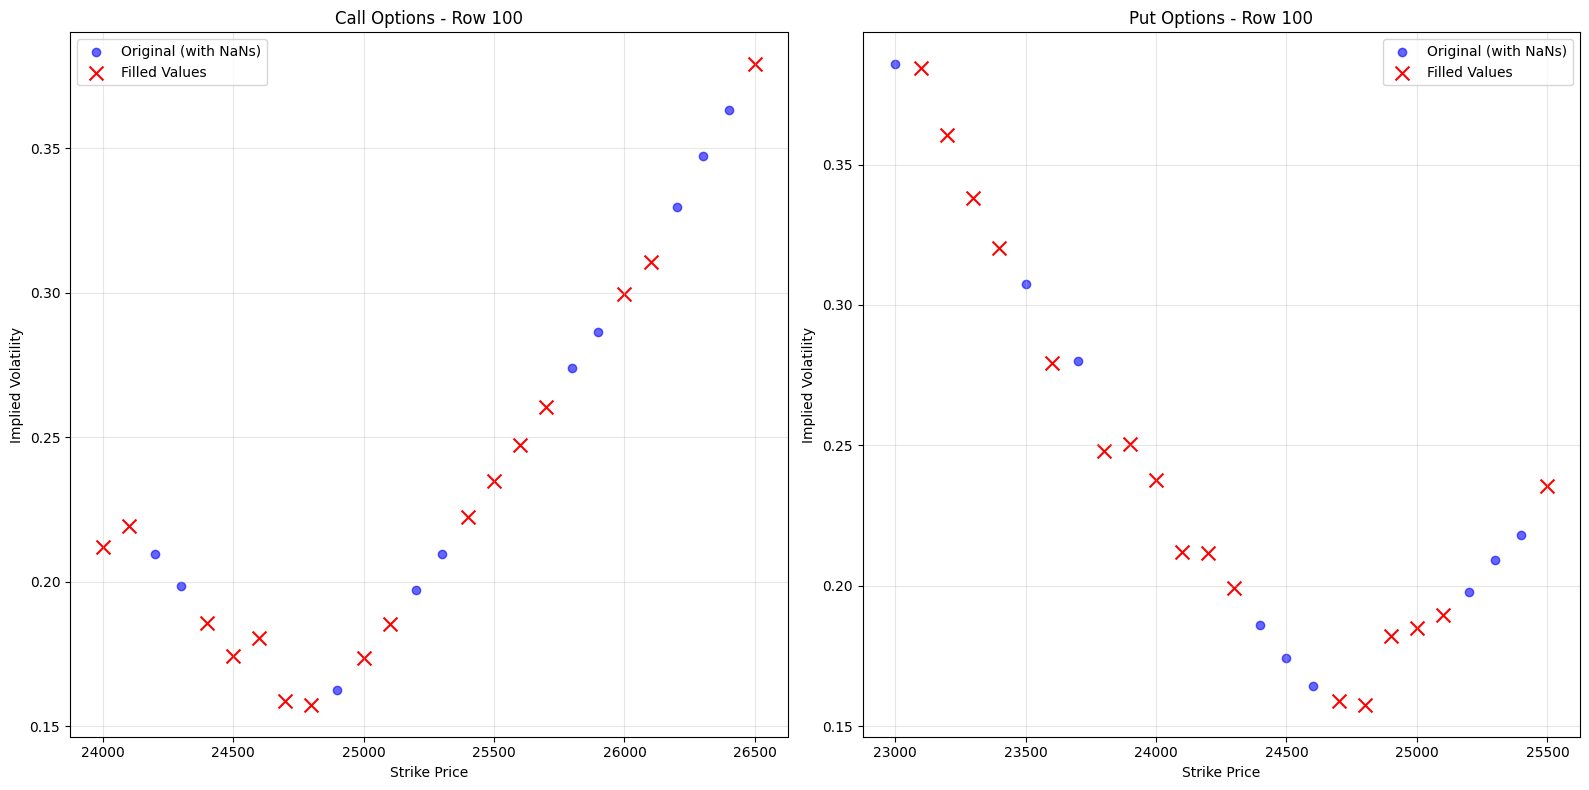

In [54]:
# Load test data into another variable for comparison
original_test_data = pd.read_parquet("data/test_data.parquet")


def compare_predictions(row_idx, data_type=["call", "put"]):
    """
    Draw a graph comparing original test data with filled data for a specific row

    Parameters:
    row_idx (int): The index of the row to plot
    data_type (list): Types of options to plot - "call", "put", or both
    """
    plt.figure(figsize=(16, 8))

    if "call" in data_type:
        call_cols = [col for col in test_pred_cols if col.startswith("call")]
        call_strikes = np.array([float(col.split("_")[-1]) for col in call_cols])

        plt.subplot(1, 2, 1)
        # Original data with NaNs
        plt.scatter(
            call_strikes,
            original_test_data.loc[row_idx, call_cols],
            color="blue",
            label="Original (with NaNs)",
            alpha=0.6,
        )

        # Plot NaN points differently
        nan_mask = original_test_data.loc[row_idx, call_cols].isna()
        plt.scatter(
            call_strikes[nan_mask],
            test_data.loc[row_idx, call_cols].values[nan_mask],
            color="red",
            marker="x",
            s=100,
            label="Filled Values",
        )

        plt.title("Call Options - Row {}".format(row_idx))
        plt.xlabel("Strike Price")
        plt.ylabel("Implied Volatility")
        plt.legend()
        plt.grid(True, alpha=0.3)

    if "put" in data_type:
        put_cols = [col for col in test_pred_cols if col.startswith("put")]
        put_strikes = np.array([float(col.split("_")[-1]) for col in put_cols])

        plt.subplot(1, 2, 2)
        # Original data with NaNs
        plt.scatter(
            put_strikes,
            original_test_data.loc[row_idx, put_cols],
            color="blue",
            label="Original (with NaNs)",
            alpha=0.6,
        )

        # Plot NaN points differently
        nan_mask = original_test_data.loc[row_idx, put_cols].isna()
        plt.scatter(
            put_strikes[nan_mask],
            test_data.loc[row_idx, put_cols].values[nan_mask],
            color="red",
            marker="x",
            s=100,
            label="Filled Values",
        )

        plt.title("Put Options - Row {}".format(row_idx))
        plt.xlabel("Strike Price")
        plt.ylabel("Implied Volatility")
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Find a row with some NaN values to demonstrate

compare_predictions(100)